In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import nltk
from wordcloud import WordCloud

In [2]:
# create dataframe from csv
df = pd.read_csv('./Task/Classification/classification_data.csv')
df.head()

,Unnamed: 0,in_reply_to_user_id,is_quote,is_retweet,like_count,quote_count,quoted_text,reply_count,retweet_count,retweet_text,text,urls_expanded_url,urls_url,relevant
0,0,9.135860e+17,False,False,0,0,NaN,1,0,NaN,@OzraeliAvi @SydneyLWatson @RitaPanahi @thejui...,https://www.theguardian.com/australia-news/201...,https://t.co/5AGrpxapqB,Relevant
1,1,2.574775e+08,False,False,2,0,NaN,1,0,NaN,@Red_dragon_fly @warr_cameron @NSWRFS Tell me ...,NaN,NaN,Relevant
2,2,NaN,False,False,0,0,NaN,0,0,NaN,Can we just have a fucking blanket ban on cele...,NaN,NaN,Relevant
3,3,1.429786e+07,False,False,0,0,NaN,0,0,NaN,"@scottsantens Scott, 🙏 for the tweets re: And...",NaN,NaN,Relevant
4,4,1.229958e+08,False,False,0,0,NaN,0,0,NaN,@Javedakhtarjadu Misleading information someti...,NaN,NaN,Irrelevant


In [3]:
# drop index column and duplicate rows 
df = df.drop(df.columns[0], axis=1)
df = df.drop_duplicates().reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   in_reply_to_user_id  3542 non-null   float64
 1   is_quote             7591 non-null   bool   
 2   is_retweet           7591 non-null   bool   
 3   like_count           7591 non-null   int64  
 4   quote_count          7591 non-null   int64  
 5   quoted_text          575 non-null    object 
 6   reply_count          7591 non-null   int64  
 7   retweet_count        7591 non-null   int64  
 8   retweet_text         0 non-null      float64
 9   text                 7591 non-null   object 
 10  urls_expanded_url    3747 non-null   object 
 11  urls_url             3747 non-null   object 
 12  relevant             7591 non-null   object 
dtypes: bool(2), float64(2), int64(4), object(5)
memory usage: 667.3+ KB


In [4]:
# retweet_text column holds no value 
df = df.drop('retweet_text', axis=1).reset_index(drop=True)
df.describe()

,in_reply_to_user_id,like_count,quote_count,reply_count,retweet_count
count,3.542000e+03,7591.000000,7591.000000,7591.000000,7591.000000
mean,3.194062e+17,11.169938,0.318667,1.375972,2.106705
std,5.055444e+17,198.442037,6.581126,29.109233,29.621685
min,1.200000e+01,0.000000,0.000000,0.000000,0.000000
25%,2.581237e+07,0.000000,0.000000,0.000000,0.000000
50%,4.328953e+08,0.000000,0.000000,0.000000,0.000000
75%,8.300799e+17,1.000000,0.000000,1.000000,0.000000
max,1.357398e+18,15352.000000,486.000000,2261.000000,2275.000000


<AxesSubplot:>

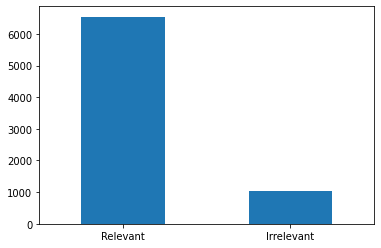

In [5]:
# plot target variable
df['relevant'].value_counts().plot(kind='bar', rot=0)

In [6]:
# can lemmatization detect typos in words? (e.g. have'nt or havent) 
# stemming or lemmatization?
# locating and correcting common typos and misspellings.
# handling of domain specific words, phrases, or acronyms.

# store urls found in tweets and compare them with two features "expanded_url" and "url" to determine if the url in tweet is a short url or expanded url

In [7]:
# preprocess text
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
def clean_tweet(tweet):
    if type(tweet) == float:
        return ""
    # lowercase all the letters
    temp = tweet.lower()
    # remove mentions and hashtags
    temp = re.sub(r"@(\w)+", "", temp)
    temp = re.sub(r"#(\w)+", "", temp)
    # remove links
    temp = re.sub(r"http\S+", "", temp)
    temp = re.sub(r"www.\S+", "", temp)
    # remove non-alphanumeric characters
    temp = re.sub(r"(\d|\W)+", " ", temp)
    # tokenization
    temp = temp.split()
    # remove stopwords
    temp = [w for w in temp if not w in stopwords]
    temp = " ".join(temp)
    return temp 

In [8]:
# clean tweet text data
df['text'] = [clean_tweet(tw) for tw in df['text']]

In [9]:
# if is_quote == True then there exists a quoted_text
# the text in quoted_text column exits in text column as well
# we drop quoted_text column since its information exists in is_quote and text columns
df = df.drop('quoted_text', axis=1)

In [10]:
# extract number of urls for each tweet
df['url_count'] = df['urls_url'].apply(lambda x: 0 if pd.isna(x) else (re.findall("[,?]", x).__len__()+1))
# check if the tweet is a reply to other tweet
df['is_reply'] = df['in_reply_to_user_id'].apply(lambda x: False if pd.isna(x) else True)
# remove unneeded columns
df = df.drop(columns=['in_reply_to_user_id', 'urls_url', 'urls_expanded_url'], axis=1)

In [11]:
# Convert "relevant" categorical data to binary data
dummies = pd.get_dummies(df['relevant'])
temp = pd.concat((df, dummies), axis=1)
temp.drop(columns=['relevant', 'Irrelevant'], inplace=True)
df = temp

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import classification_report, accuracy_score

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   is_quote       7591 non-null   bool  
 1   is_retweet     7591 non-null   bool  
 2   like_count     7591 non-null   int64 
 3   quote_count    7591 non-null   int64 
 4   reply_count    7591 non-null   int64 
 5   retweet_count  7591 non-null   int64 
 6   text           7591 non-null   object
 7   url_count      7591 non-null   int64 
 8   is_reply       7591 non-null   bool  
 9   Relevant       7591 non-null   uint8 
dtypes: bool(3), int64(5), object(1), uint8(1)
memory usage: 385.6+ KB


In [48]:
# classical text preprocessing methods
# split train and test data
X = df[df.columns[[i for i in range(9)]]]
y = df['Relevant']
df_split = [df.reset_index(drop=True) for df in train_test_split(X, y, test_size=0.2, random_state=42)]
X_train, X_test, y_train, y_test = df_split
# transform texts to numbers using bag of words method
# cv = CountVectorizer()
# fit and transform count vectorizer on training data
X_train_text = cv.fit(X_train['text']).transform(X_train['text'])
X_train_text = pd.DataFrame(X_train_text.toarray(), columns=cv.get_feature_names())
# transform testing data
X_test_text = cv.transform(X_test['text'])
X_test_text = pd.DataFrame(X_test_text.toarray(), columns=cv.get_feature_names())
# modify training and testing data
X_train = pd.concat((X_train, X_train_text), axis=1)
X_train = X_train.drop('text', axis=1)
X_test = pd.concat((X_test, X_test_text), axis=1)
X_test = X_test.drop('text', axis=1)

In [49]:
# X_train = pd.concat((X_train, X_train_text), axis=1)
# X_train = X_train.drop('text', axis=1)
# X_test = pd.concat((X_test, X_test_text), axis=1)
# X_test = X_test.drop('text', axis=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6072, 9)
(6072,)
(1519, 9)
(1519,)
